# Deep RL

## Dependencies

In [1]:
import numpy as np
# from numpy.random import default_rng
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns

In [2]:
from utils import Params
from env.RandomWalk1D import RandomWalk1D, Actions
from agent import QLearningFuncApprox, EpsilonGreedy

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [4]:
sns.set_theme(font_scale=1.5)
mpl.rcParams["font.family"] = ["Fira Sans", "sans-serif"]

## Parameters

In [5]:
p = Params(
    seed=42,
    n_runs=3,
    total_episodes=50,
    epsilon=0.1,
    alpha=0.3,
    gamma=0.95,
    learning_rate=0.001,
    nLayers=5,
    nHiddenUnits=20,
)
p

Params(seed=42, rng=None, n_runs=3, total_episodes=50, epsilon=0.1, gamma=0.95, alpha=0.3, jointRep=True, learning_rate=0.001, nLayers=5, nHiddenUnits=20, action_size=None, state_size=None)

In [6]:
# # Set the seed
# p.rng = np.random.default_rng(p.seed)

## The environment

In [7]:
env = RandomWalk1D()

In [8]:
p.action_size = len(env.action_space)
p.state_size = len(env.observation_space)
print(f"Action size: {p.action_size}")
print(f"State size: {p.state_size}")

Action size: 2
State size: 7


## Running the environment

In [9]:
learner = QLearningFuncApprox(
    learning_rate=p.alpha,
    gamma=p.gamma,
    state_size=p.state_size,
    action_size=p.action_size,
)

In [10]:
explorer = EpsilonGreedy(epsilon=p.epsilon, rng=p.rng)

In [11]:
rewards = np.zeros((p.total_episodes, p.n_runs))
steps = np.zeros((p.total_episodes, p.n_runs))
episodes = np.arange(p.total_episodes)
qtables = np.zeros((p.n_runs, p.state_size, p.action_size))
all_states = []
all_actions = []

for run in range(p.n_runs):  # Run several times to account for stochasticity
    learner.reset(
        action_size=env.numActions
    )  # Reset the Q-table and the weights between runs

    for episode in tqdm(episodes, desc=f"Run {run}/{p.n_runs} - Episodes", leave=False):
        state = env.reset()  # Reset the environment
        step = 0
        done = False
        total_rewards = 0

        while not done:
            learner.Q_hat_table = learner.Q_hat(learner.weights, learner.features)

            action = explorer.choose_action(
                action_space=env.action_space, state=state, qtable=learner.Q_hat_table
            )

            # Log all states and actions
            all_states.append(state)
            all_actions.append(action)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action)

            learner.weights[:, action] = learner.update_weights(
                state, action, reward, new_state
            )

            total_rewards += reward
            step += 1

            # Our new state is state
            state = new_state

        # Log all rewards and steps
        rewards[episode, run] = total_rewards
        steps[episode, run] = step
    qtables[run, :, :] = learner.Q_hat_table

## Visualization

In [12]:
def postprocess(episodes, p, rewards, steps, qtables):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=p.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    # res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs
    return res, qtable

In [13]:
res, qtable = postprocess(episodes, p, rewards, steps, qtables)

In [14]:
res

,Episodes,Rewards,Steps
0,0,1.0,5.0
1,1,1.0,17.0
2,2,-1.0,11.0
3,3,1.0,9.0
4,4,1.0,9.0
...,...,...,...
145,45,1.0,3.0
146,46,1.0,3.0
147,47,1.0,3.0
148,48,1.0,3.0


In [15]:
qtable

array([[ 0.        ,  0.        ],
       [-0.37      ,  0.1073023 ],
       [ 0.01798892,  0.51627833],
       [ 0.1842929 ,  0.90249457],
       [ 0.18742287,  0.9499995 ],
       [ 0.21630925,  0.99999996],
       [ 0.        ,  0.        ]])

As a sanity check, we will plot the distributions of states and actions
with the following function:

In [16]:
def plot_states_actions_distribution(states, actions):
    """Plot the distributions of states and actions."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    sns.histplot(data=states, ax=ax[0])
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(
        [item.value for item in Actions], labels=[item.name for item in Actions]
    )
    ax[1].set_title("Actions")
    fig.tight_layout()
    plt.show()

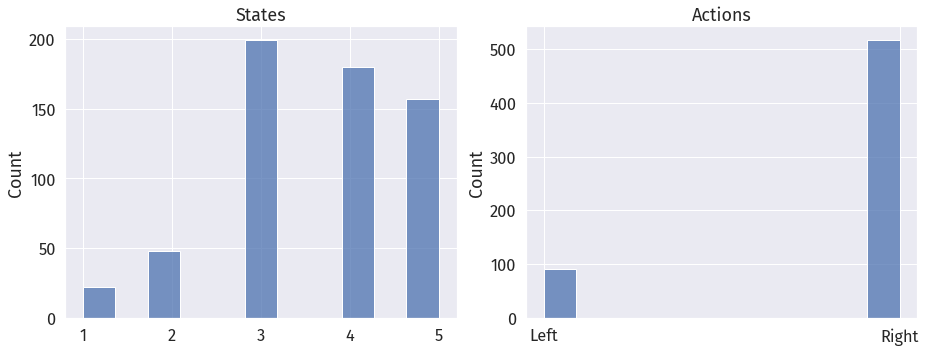

In [17]:
plot_states_actions_distribution(all_states, all_actions)

In [18]:
def plot_steps_and_rewards(df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data=df, x="Episodes", y="Rewards", ax=ax[0])
    ax[0].set(ylabel=f"Rewards\naveraged over {p.n_runs} runs")

    sns.lineplot(data=df, x="Episodes", y="Steps", ax=ax[1])
    ax[1].set(ylabel=f"Steps number\naveraged over {p.n_runs} runs")

    fig.tight_layout()
    plt.show()

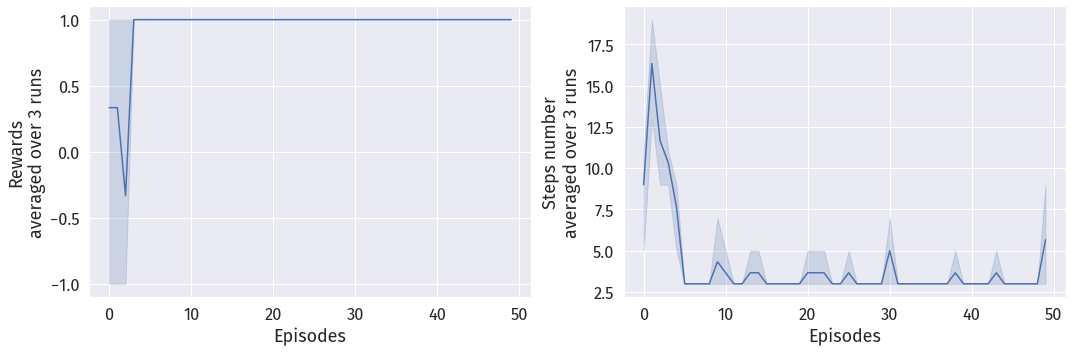

In [19]:
plot_steps_and_rewards(res)

In [20]:
qtable

array([[ 0.        ,  0.        ],
       [-0.37      ,  0.1073023 ],
       [ 0.01798892,  0.51627833],
       [ 0.1842929 ,  0.90249457],
       [ 0.18742287,  0.9499995 ],
       [ 0.21630925,  0.99999996],
       [ 0.        ,  0.        ]])

In [21]:
qtable_flat = qtable.flatten()[np.newaxis, :]
qtable_flat

array([[ 0.        ,  0.        , -0.37      ,  0.1073023 ,  0.01798892,
         0.51627833,  0.1842929 ,  0.90249457,  0.18742287,  0.9499995 ,
         0.21630925,  0.99999996,  0.        ,  0.        ]])

In [22]:
def plot_q_values():
    fig, ax = plt.subplots(figsize=(15, 1.5))
    cmap = sns.color_palette("vlag", as_cmap=True)
    chart = sns.heatmap(
        qtable.flatten()[np.newaxis, :],
        annot=True,
        ax=ax,
        cmap=cmap,
        yticklabels=False,  # linewidth=0.5
        center=0,
    )
    states_nodes = np.arange(1, 14, 2)
    chart.set_xticks(states_nodes)
    chart.set_xticklabels([str(item) for item in np.arange(0, 7, 1)])
    chart.set_title("Q values")
    ax.tick_params(bottom=True)

    # Add actions arrows
    for node in states_nodes:
        arrows_left = {"x_tail": node, "y_tail": 1.4, "x_head": node - 1, "y_head": 1.4}
        arrow = mpatches.FancyArrowPatch(
            (arrows_left["x_tail"], arrows_left["y_tail"]),
            (arrows_left["x_head"], arrows_left["y_head"]),
            mutation_scale=10,
            clip_on=False,
            color="k",
        )
        ax.add_patch(arrow)
        arrows_right = {
            "x_tail": node,
            "y_tail": 1.4,
            "x_head": node + 1,
            "y_head": 1.4,
        }
        arrow = mpatches.FancyArrowPatch(
            (arrows_right["x_tail"], arrows_right["y_tail"]),
            (arrows_right["x_head"], arrows_right["y_head"]),
            mutation_scale=10,
            clip_on=False,
            color="k",
        )
        ax.add_patch(arrow)

        # Add rectangle to separate each state pair
        rect = mpatches.Rectangle(
            (node - 1, 0),
            2,
            1,
            linewidth=2,
            edgecolor="k",
            facecolor="none",
            clip_on=False,
        )
        ax.add_patch(rect)

    plt.show()

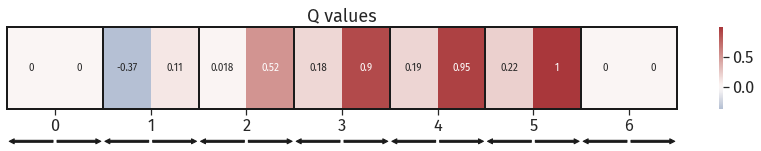

In [23]:
plot_q_values()